In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm, theano.tensor as tt
import matplotlib.pyplot as plt

%matplotlib inline

In [23]:
ts = pd.read_csv('./data/ts14-15.csv')
ts = ts.drop('Unnamed: 0', 1)

# Build team index
teams = ts.home_team.unique()
teams = pd.DataFrame(teams, columns=['team'])
teams['i'] = teams.index

ts = pd.merge(ts, teams, left_on='home_team', right_on='team', how='left')
ts = ts.rename(columns = {'i': 'i_home'}).drop('team', 1)
ts = pd.merge(ts, teams, left_on='away_team', right_on='team', how='left')
ts = ts.rename(columns = {'i': 'i_away'}).drop('team', 1)

ts = ts.sort_values(by='kick_off', ascending=1)

# Observed goals stats (Eyeball Poisson)
observed_home_goals = ts.home_score.values
observed_away_goals = ts.away_score.values

home_team = ts.i_home.values
away_team = ts.i_away.values

num_teams = len(ts.i_home.drop_duplicates())
num_games = len(home_team)

# Add back to back fixture round index t
fixtures_per_round = num_teams/2
num_rounds = 38

rounds = np.array([[x]*(fixtures_per_round) for x in range(1,39)]).flatten()
ts['t'] = 1
ts['t'] = rounds

grouped = ts.groupby('t')

observed_home_goals = np.zeros((num_rounds,fixtures_per_round))
observed_away_goals = np.zeros((num_rounds,fixtures_per_round))
home_team = np.zeros((num_rounds,fixtures_per_round))
away_team = np.zeros((num_rounds,fixtures_per_round))

for t, group in grouped:
    observed_home_goals[t-1] = group.home_score.values
    observed_away_goals[t-1] = group.away_score.values
    home_team[t-1] = group.i_home.values
    away_team[t-1] = group.i_away.values
    
observed_home_goals = observed_home_goals.astype(np.int64)
observed_away_goals = observed_away_goals.astype(np.int64)
home_team = home_team.astype(np.int64)
away_team = away_team.astype(np.int64)

T = observed_home_goals.shape[0]

ts[(ts['i_home'] == 0) | (ts['i_away'] == 0)]

,home_score,away_score,kick_off,home_team,away_team,i_home,i_away,t
10,2,1,2014-08-16,Arsenal,Crystal Palace,0,11,1
133,2,2,2014-08-23,Everton,Arsenal,7,0,2
228,1,1,2014-08-31,Leicester City,Arsenal,12,0,3
8,2,2,2014-09-13,Arsenal,Manchester City,0,9,4
95,0,3,2014-09-20,Aston Villa,Arsenal,5,0,5
7,1,1,2014-09-27,Arsenal,Tottenham Hotspur,0,8,6
19,2,0,2014-10-05,Chelsea,Arsenal,1,0,7
17,2,2,2014-10-18,Arsenal,Hull City,0,18,8
247,0,2,2014-10-25,Sunderland,Arsenal,13,0,9
15,3,0,2014-11-01,Arsenal,Burnley,0,16,10


In [4]:
# Calculate time delta between games
# Ordered ascending dates with team
ts_home = ts[['home_team', 'kick_off']]
ts_away = ts[['away_team', 'kick_off']]

ts_home.columns = ['team', 'date']
ts_away.columns = ['team', 'date']

dates = ts_home.append(ts_away)

dates = dates.sort_values(by='date', ascending=1)

dates = dates.reset_index(drop=False)

dates['date'] = pd.to_datetime(dates['date'])
dates['time_delta'] = 0

# Group by team
dates_grouped = dates.groupby('team')

# calculate time delta
for name, group in dates_grouped:
    time_delta = group['date'].diff()
    days = (time_delta / np.timedelta64(1, 'D'))
    days = days.fillna(0).astype(int)
    dates.ix[days.index,'time_delta'] = days

# add to original dataframe where (team in home and date OR team in away and date)
dates = dates.set_index('index')

ts['home_time_delta'] = 0
ts['away_time_delta'] = 0

dates0 = dates.ix[dates.index.duplicated()]
dates1 = dates.ix[-dates.index.duplicated()]

ts = ts.sort_index()

dates0 = dates0.sort_index()
dates1 = dates1.sort_index()

ts.set_value(dates0['team'] == ts['home_team'],['home_time_delta'],dates0['time_delta'])
ts.set_value(dates1['team'] == ts['home_team'],['home_time_delta'],dates1['time_delta'])

ts.set_value(dates0['team'] == ts['away_team'],['away_time_delta'],dates0['time_delta'])
ts.set_value(dates1['team'] == ts['away_team'],['away_time_delta'],dates1['time_delta'])

ts = ts.sort_values(by='kick_off', ascending=1)

In [5]:
with pm.Model() as model:    
    # global model parameters
    home = pm.Normal('home', mu=0, tau=0.0001)
    tau_att = pm.Gamma('tau_att', alpha=0.1, beta=0.1)
    tau_def = pm.Gamma('tau_def', alpha=0.1, beta=0.1)
    intercept = pm.Normal('intercept', mu=0, tau=0.0001)

    # Make auto-regressive
    # Each t indexes a home or away fixture for each team (10 games with 20 teams)
    # [1] Define t0
    # TODO: Incorporate time_deltas in tau
    atts_ni = [pm.Normal("atts_ni0", mu = 0, tau = tau_att, shape = num_teams)]
    defs_ni = [pm.Normal("defs_ni0", mu = 0, tau = tau_def, shape = num_teams)]
    
    # Identifiability
    atts = [pm.Deterministic('atts0', atts_ni[0] - tt.mean(atts_ni[0]))]
    defs = [pm.Deterministic('defs0', defs_ni[0] - tt.mean(defs_ni[0]))]
    
    home_thetas = [tt.exp(intercept + home + atts[0][home_team[0,:]] + defs[0][away_team[0,:]])]
    away_thetas = [tt.exp(intercept + atts[0][away_team[0,:]] + defs[0][home_team[0,:]])]
    
    home_points = [pm.Poisson('home_points0', mu=home_thetas[0], observed=observed_home_goals[0,:])]
    away_points = [pm.Poisson('away_points0', mu=away_thetas[0], observed=observed_away_goals[0,:])]
    
    # [2] Define t1-T: "stack plates"
    # [b] take time delta adjusted variance into account
    #     (http://mathworld.wolfram.com/RandomWalk1-Dimensional.html)
    # Is 0 for time_delta ok, since we are in log space?
    # atts_ni ~ latent attack paramter not respecting the identifiability constraint yet
    # Keep innovation variance global
    for t in range(1,T):
        # assumption 1: tau_att will be a <num_teams> sized vector of priors
        # assumption 2: atts_ni are ordered by team index (the mask later picks the right parameters)
        #                - hence order time deltas by team index
        # Find round deltas: Order team deltas by ascending team index
        home_ix = ts[(ts.t == t+1)]['i_home'].values
        away_ix = ts[(ts.t == t+1)]['i_away'].values
        home_deltas = ts[(ts.t == t+1)]['home_time_delta'].values
        away_deltas = ts[(ts.t == t+1)]['away_time_delta'].values        
        ix = np.concatenate((home_ix, away_ix))
        deltas = np.concatenate((home_deltas, away_deltas))
        mask = np.argsort(ix)
        round_deltas = deltas[mask]
        
        # Random walks with TIME DRIFT
        atts_ni.append(pm.Normal("atts_ni{0}".format(t),
                                 mu = atts[t-1],
                                 tau = tau_att,
                                 shape = num_teams))
        defs_ni.append(pm.Normal("defs_ni{0}".format(t),
                                 mu = defs[t-1],
                                 tau = tau_def,
                                 shape = num_teams))
        
        atts.append(pm.Deterministic("atts{0}".format(t), atts_ni[t] - tt.mean(atts_ni[t])))
        defs.append(pm.Deterministic("defs{0}".format(t), defs_ni[t] - tt.mean(defs_ni[t])))
        
        home_thetas.append(tt.exp(intercept + home + atts[t][home_team[t,:]] + defs[t][away_team[t,:]]))
        away_thetas.append(tt.exp(intercept + atts[t][away_team[t,:]] + defs[t][home_team[t,:]]))

        # likelihood of observed data
        home_points.append(pm.Poisson("home_points{0}".format(t), mu=home_thetas[t], observed=observed_home_goals[t,:]))
        away_points.append(pm.Poisson("away_points{0}".format(t), mu=away_thetas[t], observed=observed_away_goals[t,:])) 

Applied log-transform to tau_att and added transformed tau_att_log to model.
Applied log-transform to tau_def and added transformed tau_def_log to model.


In [6]:
# Choose starting point based on ADVI fit
with model:
    mu, sds, elbo = pm.variational.advi(n=100000)

Iteration 0 [0%]: ELBO = -3538.07
Iteration 10000 [10%]: ELBO = -1792.44
Iteration 20000 [20%]: ELBO = -1661.09
Iteration 30000 [30%]: ELBO = -1656.73
Iteration 40000 [40%]: ELBO = -1672.28
Iteration 50000 [50%]: ELBO = -1700.27
Iteration 60000 [60%]: ELBO = -1756.16
Iteration 70000 [70%]: ELBO = -1741.51
Iteration 80000 [80%]: ELBO = -1562.29
Iteration 90000 [90%]: ELBO = -1658.51
Finished [100%]: ELBO = -1562.85


In [7]:
# MCMC
with model:
    start = mu
    step = pm.Metropolis()
    trace = pm.sample(60000, step)

 [-----------------100%-----------------] 60000 of 60000 complete in 2219.3 sec

In [8]:
##### Thinning: Discard every but the 3rd element
# Burn-in: Discard first 1500 samples until in static regime
att_samples = trace['atts0']
thinning = np.arange(0, att_samples.shape[0], 5)
thinburn = thinning[500::]
thinburn

array([ 2500,  2505,  2510, ..., 59985, 59990, 59995])

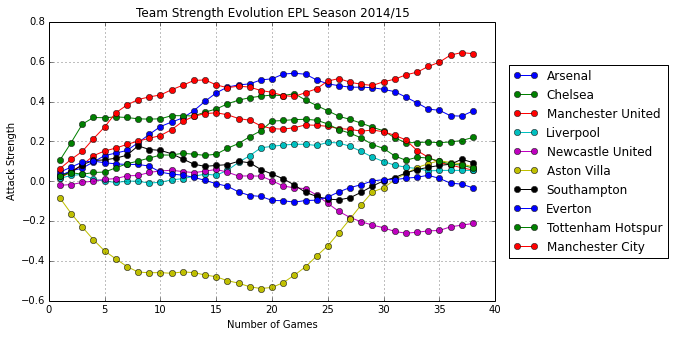

In [27]:
atts = []

for t in range(T):
    tmp = trace['atts{0}'.format(t)][thinburn,:]
    tmp = np.swapaxes(tmp,0,1)
    atts.append([n.mean() for n in tmp])
    
atts = np.swapaxes(atts,0,1)
x = range(1,T+1)
# Adjust x axis starting form 1
# x = range(1,T+1)

fig, ax = plt.subplots()
fig.set_size_inches(8, 5)

for i in range(10):
    plt.plot(x, atts[i], marker='o', label=teams['team'][i])

plt.title('Team Strength Evolution EPL Season 2014/15')
plt.xlabel('Number of Games')
plt.ylabel('Attack Strength')
plt.legend(bbox_to_anchor=(1.4, 0.5), loc='right', ncol=1)

plt.savefig('/Users/moe/Desktop/Drive/UCL/thesis/Oxford-Template/figures/attack-evolution.pdf')

plt.grid()
plt.show()

In [10]:
ppc = pm.sample_ppc(trace, samples=1, model=model, size=100)

In [11]:
# home_points<0-37>
# away_points<0-37>
# Convert to shape (380, 100)
print(ppc['away_points0'].shape)

import re

home = np.ndarray(shape=(380,100))
away = np.ndarray(shape=(380,100))

for key in ppc.keys():
    if ('home' in key):
        t = re.findall('\d+', key)
        t = int(t[0])
        tmp = ppc[key]
        tmp = np.squeeze(tmp)
        tmp = np.swapaxes(tmp,1,0)
        t_mask = range(t*10,t*10+10)
        home[t_mask,] = tmp
        
    elif ('away' in key):
        t = re.findall('\d+', key)
        t = int(t[0])
        tmp = ppc[key]
        tmp = np.squeeze(tmp)
        tmp = np.swapaxes(tmp,1,0)
        t_mask = range(t*10,t*10+10)
        away[t_mask,] = tmp
        
print(home.shape) # TODO: VERIFY THAT SAMPLES ARE INDEXED CORRECTLY!!!
print(away.shape) # TODO: VERIFY THAT SAMPLES ARE INDEXED CORRECTLY!!!

(1, 100, 10)
(380, 100)
(380, 100)


In [13]:
# Calculate goal differences
from collections import Counter

predictions = []

# Save odds for outcomes for each fixture
exp_win = np.empty(380,)
exp_draw = np.empty(380,)
exp_loss = np.empty(380,)
exp_events = np.chararray((380,)) # expected events
real_events = np.chararray((380,)) # Realised events
    
for g in range(num_games): # num_games
    g_home = home[g]
    g_away = away[g]
    g_home_team = home_team.flatten()[g]
    g_away_team = away_team.flatten()[g]
    home_teamname = teams['team'][g_home_team]
    away_teamname = teams['team'][g_away_team]    
    
    g_diff = [x[0] - x[1] for x in zip(g_home, g_away)]
    freqs = Counter(g_diff).items()

    rel_freqs = [(x[0],float(x[1])/100) for x in freqs]

    exp_win[g] = sum([x[1] for x in rel_freqs if x[0] > 0])
    exp_draw[g] = sum([x[1] for x in rel_freqs if x[0] == 0])
    exp_loss[g] = sum([x[1] for x in rel_freqs if x[0] < 0])
    
    results = [exp_win[g], exp_draw[g], exp_loss[g]] # 0 = win; 1 = draw; 2 = loss;
    event_mnemonics = ['Win', 'Draw', 'Loss']
    exp_events[g] = event_mnemonics[results.index(max(results))]
    
    actual_g_diff = observed_home_goals.flatten()[g] - observed_away_goals.flatten()[g]
    if (actual_g_diff > 0): real_events[g] = event_mnemonics[0]
    elif (actual_g_diff == 0): real_events[g] = event_mnemonics[1]
    else: real_events[g] = event_mnemonics[2]
            
exp_events
real_events

# Check if properly normalised
# What to do about precision??
(exp_loss + exp_win + exp_draw) == 1

## Calculate log-likelihood
# exp_* arrays contain the relative frequencies of the respective
# events from the simulated fixtures (100 samples each)
# We look at the actual realised fixture results in real_events
# and add the log-likelihood our model assigns this result for every individual outcome 
likelihood = np.empty(380,)

for g,event in enumerate(real_events):
    if (event == 'W'): likelihood[g] = exp_win[g]
    elif (event == 'D'): likelihood[g] = exp_draw[g]
    else: likelihood[g] = exp_loss[g]
        
ll = np.log(likelihood)

# Output log likelihood for total season 13/14
avg_ll = ll.sum()/len(ll)
bias = 0

print "Avg LL = " + str(avg_ll)
print "Bias = " + str(bias)

Avg LL = -0.968523922693
Bias = 0
